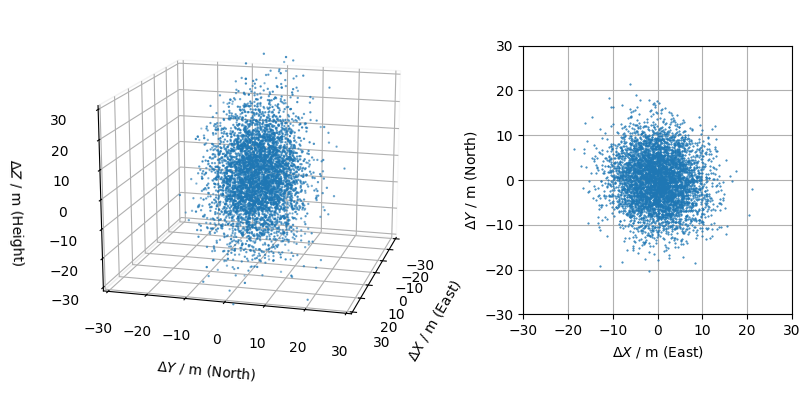

In [2]:
# Example 16: position calculation from measured data
# SPDX-FileCopyrightText: Copyright (C) 2023 Andreas Naber <annappo@web.de>
# SPDX-License-Identifier: GPL-3.0-only

%matplotlib widget 

import json
import gpslib
import numpy as np
import matplotlib.pyplot as plt
import datetime

N_CYC = 32
LSF_WEIGHT = True
MAX_RESIDUAL = 1.0E-7
LSF_MAX_IT = 10
HEIGHT = 165.7              
HEIGHT_DEV = 10             # allowed standard deviation for height
SAT_ALL = [12,17,25,24,19,15,13,10,22,32,23]

PLOT_RANGE = 30             # in meter
MAX_NO_POS = 5000           # number of positions to be calculated 
                            # (max is 13060)
SAT_LIST = SAT_ALL
CALC_MIN = 11               # sets the minimum number of sats for the 
                            # calculation
CONFINE_HEIGHT = False      # if True HEIGHT is used as a constraint


def loadJsonLst(fname):
    with open(fname,'r') as file:
        lst = json.load(file)  
    return lst

# resLst = list of tuples (satNo,tow,x,y,z,smpTime,weekNum,streamNo,cpStd)
def ecefPositions(resLst,maxNoPos):   
    minSat = 3 if CONFINE_HEIGHT else 4
    calcSat = max(CALC_MIN,minSat)
    locStart = [0,0,0,0]                         
    
    lsfFailLst,lsfExcLst,recPosLst = [],[],[]

    noPos = 0
    r = 0
    resLst.sort(key = lambda e: (e[1],e[7],e[0]))
    while r < len(resLst):
        bLst=[resLst[r]]
        tow,streamNo = resLst[r][1],resLst[r][7]
        r += 1
        while r < len(resLst) and (resLst[r][1],resLst[r][7])==(tow,streamNo):
            bLst.append(resLst[r])
            r += 1            
        nSat = len(bLst)
        if nSat >= calcSat:              
            satCoord = np.zeros((3,nSat))
            timeDel = np.zeros(nSat)
            timeStd = np.zeros(nSat)
            for i in range(nSat):
                weeknum = bLst[i][6]
                satCoord[:,i]=bLst[i][2:5]
                timeDel[i] = bLst[i][5]
                timeStd[i] = bLst[i][8]   
            stdDev = timeStd if LSF_WEIGHT else None

            try:
                # output: recPos = (t0,x,y,z)                
                recPos,res,_,_ = gpslib.leastSquaresPos(minSat,
                                                satCoord,timeDel,
                                                maxResidual=MAX_RESIDUAL,
                                                maxIt=LSF_MAX_IT,
                                                recPos=locStart,
                                                height=HEIGHT,
                                                hDev=HEIGHT_DEV,
                                                stdDev=stdDev) 
            except:
                lsfExcLst.append((tow,streamNo)) 
            else:
                if res[-1] <= MAX_RESIDUAL:
                    gpsTime = gpslib.gpsTime(tow,weeknum)\
                             +datetime.timedelta(seconds=streamNo*N_CYC/1000)
                    # POSIX (UNIX) time in sec 
                    recPos[0] = gpsTime.timestamp()                      
                    recPosLst.append(recPos)         # recPos=(gpsTime,x,y,z)
                    noPos += 1
                    if noPos >= maxNoPos:
                        break
                else:
                    lsfFailLst.append((tow,streamNo))                                              
                    
    return recPosLst,lsfFailLst,lsfExcLst
    
    
resLst = loadJsonLst('../data/gpsPositions_140923_2.json')
resLst = list(filter(lambda item: item[0] in SAT_LIST,resLst))

recPosLst,lsfFailLst,lsfExcLst = ecefPositions(resLst,MAX_NO_POS)
_,xs,ys,zs = zip(*recPosLst)
xm,ym,zm = np.mean(xs),np.mean(ys),np.mean(zs)
ecefMeanPos = (xm,ym,zm)

locTrack = []
geoMeanPos = gpslib.ecefToGeo(ecefMeanPos)  # geo = (lat,lon,height)
for recPos in recPosLst:
    geoPos = gpslib.ecefToGeo(recPos[1:])     
    locX,locY = gpslib.locDistFromLatLon(geoMeanPos,geoPos) 
    locZ = geoPos[2]-geoMeanPos[2]
    locTrack.append((locX,locY,locZ))                            

locX,locY,locZ = zip(*locTrack)
locStdDev = np.std((locX,locY,locZ),axis=1)
        
# --- plot results ----------------    
    
fig = plt.figure(figsize = (8,4))
fig.canvas.header_visible = False
spec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(spec[0, 0],projection='3d')
ax2 = fig.add_subplot(spec[0, 1],aspect='equal')
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.99, top=.95, 
                    wspace=.5, hspace=0)

ax1.scatter(locX, locY, locZ, marker='o',s=0.5)
ax1.view_init(elev=15, azim=15)
ax1.set_box_aspect(None, zoom=1.4)

ax1.set_xlim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_ylim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_zlim(-PLOT_RANGE,PLOT_RANGE)
ax1.set_xlabel('$\Delta X$ / m (East)') 
ax1.set_ylabel('$\Delta Y$ / m (North)')
ax1.set_zlabel('$\Delta Z$ / m (Height)')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.grid(True)

ax2.plot(locX,locY,'o',ms=.5)
ax2.set_xlim(-PLOT_RANGE,PLOT_RANGE)
ax2.set_ylim(-PLOT_RANGE,PLOT_RANGE)
ax2.set_xlabel('$\Delta X$ / m (East)') 
ax2.set_ylabel('$\Delta Y$ / m (North)')
ax2.grid()

plt.show()    